In [66]:
import Recomandation_models as rm
import Filtering as fl
import pandas as pd
import numpy as np

import math
from time import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torch.utils.data as data
import torch.distributions as dist

### DATA PREPARATION

In [67]:
class Spatial_F_AE(nn.Module):
    def __init__(self,k):
        super(Spatial_F_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(k,500),
            nn.ReLU(),
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,125),
            nn.ReLU(),
            nn.Linear(125,50),
            nn.ReLU(),
            nn.Linear(50,2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,50),
            nn.ReLU(),
            nn.Linear(50,125),
            nn.ReLU(),
            nn.Linear(125,250),
            nn.ReLU(),
            nn.Linear(250,500),
            nn.ReLU(),
            nn.Linear(500,k),
            nn.Sigmoid(),
        )
    def forward(self,x):
        z = self.encoder(x)
        final = self.decoder(z)
        return final

In [98]:
class Spatial_F_AE2(nn.Module):
    def __init__(self,k):
        super(Spatial_F_AE2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(k,750),
            nn.ReLU(),
            nn.Linear(750,500),
            nn.ReLU(),
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,125),
            nn.ReLU(),
            nn.Linear(125,75),
            nn.ReLU(),
            nn.Linear(75,50),
            nn.ReLU(),
            nn.Linear(50,25),
            nn.ReLU(),
            nn.Linear(25,10),
            nn.ReLU(),
            nn.Linear(10,2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,10),
            nn.ReLU(),
            nn.Linear(10,25),
            nn.ReLU(),
            nn.Linear(25,50),
            nn.ReLU(),
            nn.Linear(50,75),
            nn.ReLU(),
            nn.Linear(75,125),
            nn.ReLU(),
            nn.Linear(125,250),
            nn.ReLU(),
            nn.Linear(250,500),
            nn.ReLU(),
            nn.Linear(500,750),
            nn.ReLU(),
            nn.Linear(750,k),
            nn.Sigmoid(),
        )
    def forward(self,x):
        z = self.encoder(x)
        final = self.decoder(z)
        return final

In [69]:
def train(model, dataloader, criterion, optimizer, num_epochs, scheduler=None, best_loss=float('inf')):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    losses = []
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            inputs = batch[0]
            inputs = inputs.to(device)
            recon = model(inputs)
            loss = criterion(recon, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step(loss.item())
            running_loss += loss.item()
        losses.append(running_loss / (i + 1))
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch+1}: Loss = {running_loss / (i + 1):.10f}")
    return losses

In [70]:
df_books = pd.read_csv('books_autorec.csv')
df_books.sort_values(by='ratings_count', ascending=False, inplace=True)
#for aumenting books number change 
Books_number = 2000
df_books = df_books.iloc[:Books_number]
df_books.to_csv('Spatial_model_books.csv')
df_books['goodreads_book_id'] = df_books['goodreads_book_id'].astype(int)
book_ids = df_books['goodreads_book_id']


In [71]:
df_books = pd.read_csv('Spatial_model_books.csv')

In [72]:
df = pd.read_csv("books_autorec.csv")
df_ratings = pd.read_csv("ratings_autorec.csv")

df_ratings_with_clusters = df_ratings.merge(
    df[['goodreads_book_id', 'cluster']], 
    left_on='book_id', 
    right_on='goodreads_book_id', 
    how='left'
)

# create dictionary with user and ratings
sparse_users = {}
for user_id, group in df_ratings_with_clusters.groupby('user_id'):
    books_ratings_clusters = group[['book_id', 'rating', 'cluster']].values.tolist()
    sparse_users[user_id] = books_ratings_clusters

cluster_sizes = df_books['cluster'].value_counts().sort_index().values

filter_users = {
    user: [triplet for triplet in triplets if triplet[0] in book_ids]
    for user, triplets in sparse_users.items()
}
filter_users = {user: triplets for user, triplets in filter_users.items() if triplets}
#user taken
taken_users = 20000
filter_users = sorted(filter_users.items(), key=lambda x: len(x[1]), reverse=True)[:taken_users]
filter_users = dict(filter_users)


In [73]:
print(len(sparse_users))
print(len(filter_users))

53424
20000


In [74]:
mapping_pos_to_books = dict(zip(range(Books_number), book_ids))
mapping_books_to_pos = dict(zip(book_ids,range(Books_number)))
mapping_pos_to_users = dict(zip(range(taken_users), filter_users.keys()))
mapping_users_to_pos = dict(zip(filter_users.keys(),range(taken_users)))
print(len(mapping_pos_to_books))
print(len(mapping_books_to_pos))
print(len(mapping_pos_to_users))
print(len(mapping_users_to_pos))

2000
2000
20000
20000


In [75]:
n_books = len(mapping_books_to_pos)
user_vectors = []
for user_id, triplets in filter_users.items():
    vector = np.zeros(n_books)  # inizializza vettore di zeri

    for book_id, rating, _ in triplets:
        if book_id in mapping_books_to_pos:  # se il book_id è tra quelli mappati
            index = mapping_books_to_pos[book_id]
            vector[index] = rating  # inserisci il rating nella posizione giusta

    user_vectors.append(vector)
print(len(user_vectors))
print(len(user_vectors[0]))
for i in range(len(user_vectors)):
    user_vectors[i] = [0 if elem < 3 else 1 for elem in user_vectors[i]]
print(user_vectors[0])
df_input_data = pd.DataFrame(user_vectors)

20000
2000
[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [81]:
#df_input_data = pd.read_csv('Spatial_model_inputs.csv')
tensor_data = torch.tensor(df_input_data.values, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(tensor_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [82]:
model = rm.Spatial_F_AE(Books_number)
criterion = nn.MSELoss()
N_Epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=False)

In [149]:
losses = train(model,dataloader,criterion, optimizer, N_Epochs, scheduler)

Epoch 1: Loss = 0.0134
Epoch 2: Loss = 0.0049
Epoch 3: Loss = 0.0049
Epoch 4: Loss = 0.0049
Epoch 5: Loss = 0.0049
Epoch 6: Loss = 0.0048
Epoch 7: Loss = 0.0049
Epoch 8: Loss = 0.0048
Epoch 9: Loss = 0.0048
Epoch 10: Loss = 0.0048
Epoch 11: Loss = 0.0048
Epoch 12: Loss = 0.0048
Epoch 13: Loss = 0.0048
Epoch 14: Loss = 0.0048
Epoch 15: Loss = 0.0048
Epoch 16: Loss = 0.0048
Epoch 17: Loss = 0.0048
Epoch 18: Loss = 0.0048
Epoch 19: Loss = 0.0048
Epoch 20: Loss = 0.0048


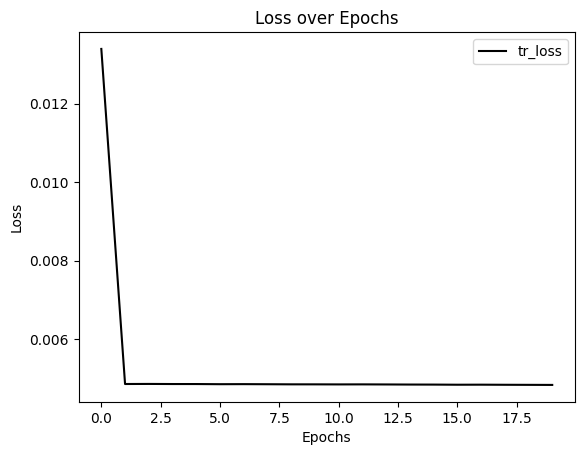

In [150]:
rm.loss_graph(losses, N_Epochs)

In [ ]:
model2 = Spatial_F_AE2(Books_number)
criterion = nn.MSELoss()
N_Epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=False)

Epoch 1: Loss = 0.0036895720
Epoch 2: Loss = 0.0036892408
Epoch 3: Loss = 0.0036889118
Epoch 4: Loss = 0.0036885840
Epoch 5: Loss = 0.0036882574
Epoch 6: Loss = 0.0036879323
Epoch 7: Loss = 0.0036876085
Epoch 8: Loss = 0.0036872859
Epoch 9: Loss = 0.0036869644
Epoch 10: Loss = 0.0036866444
Epoch 11: Loss = 0.0036863257
Epoch 12: Loss = 0.0036860091
Epoch 13: Loss = 0.0036856939
Epoch 14: Loss = 0.0036853795
Epoch 15: Loss = 0.0036850658
Epoch 16: Loss = 0.0036847522
Epoch 17: Loss = 0.0036844395
Epoch 18: Loss = 0.0036841288
Epoch 19: Loss = 0.0036838185
Epoch 20: Loss = 0.0036835086


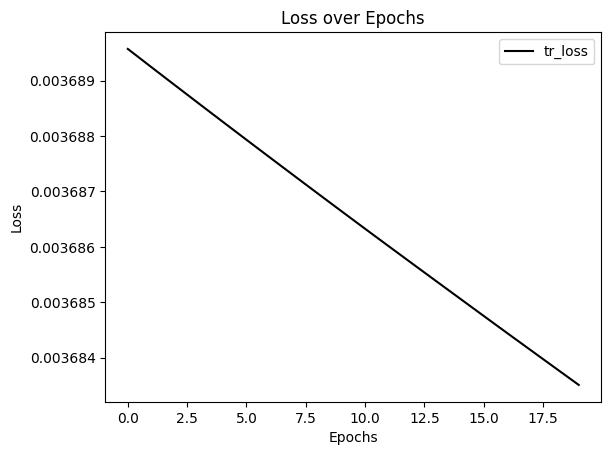

In [106]:
losses = train(model,dataloader,criterion, optimizer, N_Epochs, scheduler)
rm.loss_graph(losses, N_Epochs)

In [107]:
def recomandations(user, model):
    model.eval()
    recon = model(user)
    old_books= (user != 0).nonzero(as_tuple=True)[0].tolist()
    _, new_books = torch.topk(recon, 25)
    new_books = new_books.tolist()
    old_books_map = [mapping_pos_to_books[pos] for pos in old_books]
    new_books_map = [mapping_pos_to_books[pos] for pos in new_books]
    old_titles = [df_books[df_books['goodreads_book_id'] == id].values.tolist()[0][5] for id in old_books_map]
    new_titles = [df_books[df_books['goodreads_book_id'] == id].values.tolist()[0][5] for id in new_books_map]
    diff = list(set(new_titles) - set(old_titles))
    diff_id = list(set(new_books_map) - set(old_books_map))
    return diff, diff_id, old_books_map